# **Entrenamiento de los modelos CSP y LDA con los datos del sujeto Adriana** 

In [81]:
import os
import numpy as np
import mne # Libreria para análisis de EEG
import matplotlib.pyplot as plt
from mne.filter import filter_data
from mne.decoding import CSP
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import pickle
# Cargamos los archivos GDF de las evaluaciones de Adriana
ruta = r'.\Real_time_signal_ADRIANA.gdf'
raw = mne.io.read_raw_gdf(ruta, preload = True) 

Extracting EDF parameters from f:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Real_time_signal_ADRIANA.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8
Creating raw.info structure...
Reading 0 ... 66015  =      0.000 ...   264.060 secs...


C:\Users\dell\AppData\Local\Temp\ipykernel_15808\3391087243.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_gdf(ruta, preload = True)


In [82]:
print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel ...
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: X, last_name: >
>


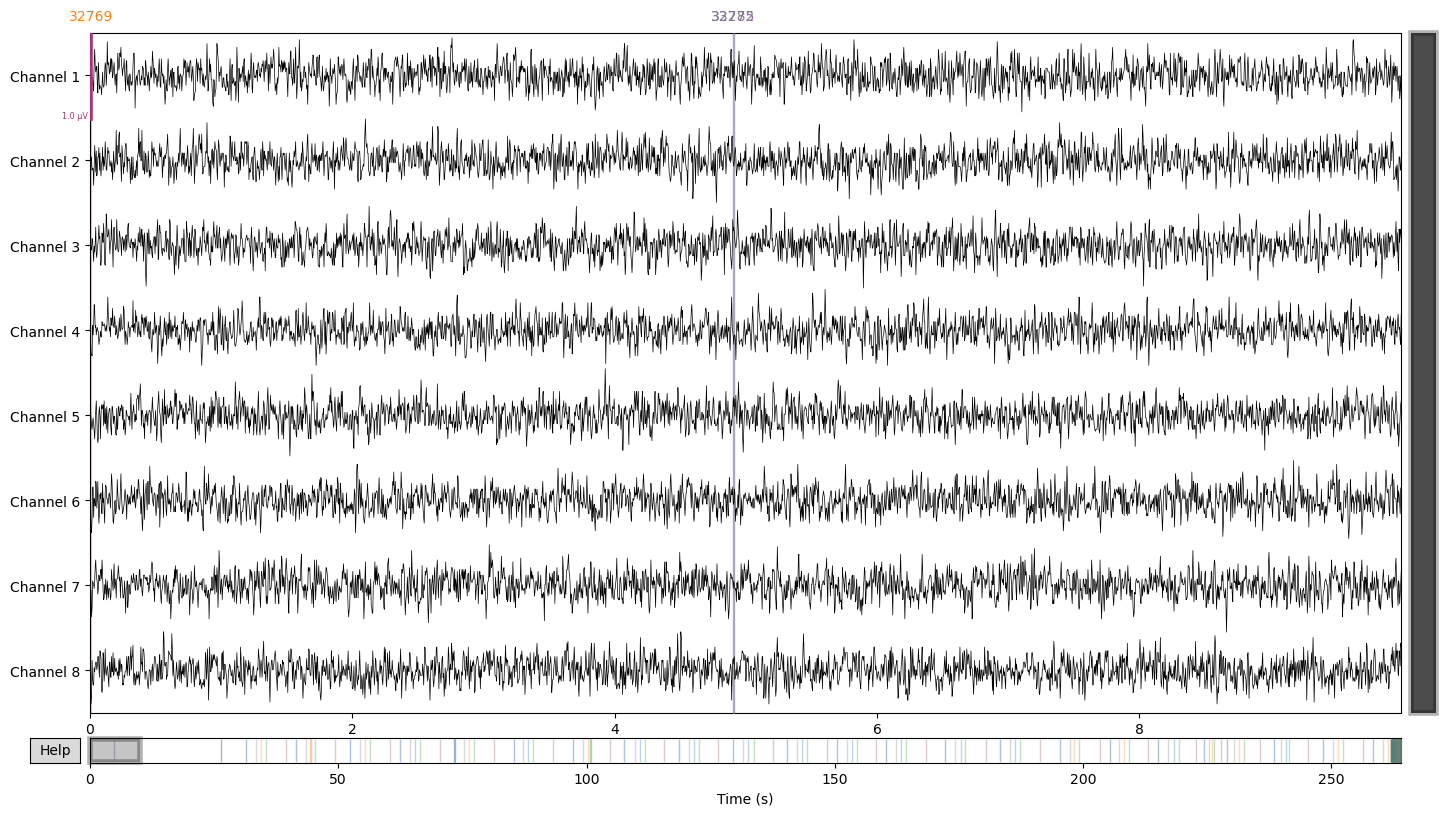

In [83]:
# Grafica de las señales EEG
fig = raw.plot(scalings={'eeg': 5e-7}, show=False)
fig.set_size_inches(15, 8) # Ajustamos el tamaño de la figura a 12(ancho)x3(altura) pulgadas
plt.show()

In [84]:
events = mne.events_from_annotations(raw)
events

Used Annotations descriptions: ['1010', '32769', '32770', '32775', '32776', '33281', '33282', '33284', '768', '769', '770', '781', '786', '800']


(array([[    1,     0,     2],
        [ 1226,     0,     4],
        [ 1226,     0,     7],
        [ 6602,     0,     5],
        [ 6602,     0,     7],
        [ 7845,     0,     9],
        [ 7845,     0,    13],
        [ 8345,     0,     7],
        [ 8601,     0,    11],
        [ 8845,     0,    12],
        [ 9857,     0,    14],
        [10349,     0,     9],
        [10349,     0,    13],
        [10854,     0,     7],
        [11102,     0,    11],
        [11350,     0,    12],
        [12349,     0,    14],
        [13103,     0,     9],
        [13103,     0,    13],
        [13605,     0,     7],
        [13857,     0,    11],
        [14102,     0,    12],
        [15103,     0,    14],
        [15605,     0,     9],
        [15605,     0,    13],
        [16099,     0,     7],
        [16350,     0,    10],
        [16603,     0,    12],
        [17620,     0,    14],
        [18352,     0,     9],
        [18352,     0,    13],
        [18844,     0,     7],
        

C:\Users\dell\AppData\Local\Temp\ipykernel_15808\3899948568.py:16: RuntimeWarning: event 12 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
C:\Users\dell\AppData\Local\Temp\ipykernel_15808\3899948568.py:16: RuntimeWarning: event 13 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
C:\Users\dell\AppData\Local\Temp\ipykernel_15808\3899948568.py:16: RuntimeWarning: event 14 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
C:\Users\dell\AppData\Local\Temp\ipykernel_15808\3899948568.py:16: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_s

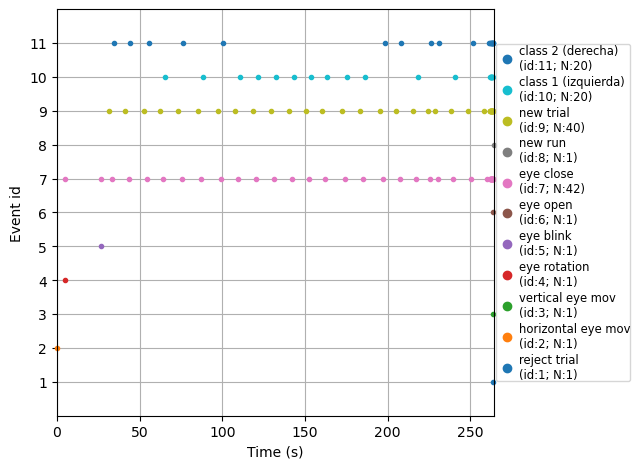

In [85]:
# Nodificar los nombres de acorde al id de cada evento
event_dict = {
    'reject trial': 1, # No lo necesitamos
    'horizontal eye mov': 2, # No lo necesitamos
    'vertical eye mov': 3, # No lo necesitamos
    'eye rotation': 4, # No lo necesitamos
    'eye blink': 5, # No lo necesitamos
    'eye open': 6, # No lo necesitamos
    'eye close': 7, # No lo necesitamos
    'new run': 8, # Inicio de una nuevo ensayo
    'new trial': 9, # Ensayos que debemos descartar debido a que contienen artefactos (Etiquetados por expertos)
    'class 1 (izquierda)': 10, # Imaginacion motora de mano izquierda
    'class 2 (derecha)': 11, # Imaginacion motora de mano derecha
}
# Visualizamos los eventos
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

In [86]:
# Tomamos ventanas de tiempo de 0.5s a 4s despues del evento para entrenar el modelo CSP
epoch = mne.Epochs(raw, events=events[0], event_id=[10,11], tmin = 0.5, tmax = 4, baseline=None) 
epoch.get_data().shape

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 876 original time points ...
18 bad epochs dropped


(22, 8, 876)

In [87]:
# 0 = izquierda y 1 = derecha
labels = epoch.events[:, -1]
labels1 = labels - 10  # Convertimos las etiquetas a 0 y 1
labels1

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1])

In [88]:
features = epoch.get_data()

Using data from preloaded Raw for 22 events and 876 original time points ...


In [89]:
def filter_band_features(features, fs, flow, fhigh):
    filtered_features = filter_data(features, fs, flow, fhigh)
    return filtered_features
# Para el entrenamiento de CSP tradicional
filtered_features = filter_band_features(features, fs=250, flow=8, fhigh=30)

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



### ***Entrenamiento del CSP y LDA con Cross-Validation***

In [90]:
csp_params = dict(
    n_components=1,
    reg='ledoit_wolf',
    log=True,
    norm_trace=False,
    cov_est='epoch'
)   

In [91]:
def generar_ventanas_pequenas(X_trial, label, csp, fs):
    win = int(1 * fs) # Tamaño de ventana ajustado a 250 muestras (1seg)            
    step = int(0.0625 * fs) # Son 15 muestras       

    X_win = [] # Features CSP de cada ventana
    Y_win = [] # Labels de cada ventana

    idx = 0
    while idx + win <= X_trial.shape[1]: # Evita sobrepasar el final del trial de 4 seg (1000 muestras)
        segment = X_trial[:, idx:idx+win] # Extrae la ventana de 1 segundo actual
        feat = csp.transform(segment[np.newaxis, :, :])[0] # Aplica filtrado espacial
        X_win.append(feat)
        Y_win.append(label)
        idx += step # Incrementa el índice por el paso definido

    return X_win, Y_win

In [92]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = []

fs = raw.info['sfreq']

for fold, (train_idx, test_idx) in enumerate(cv.split(filtered_features, labels), start=1):
    print(f"\n========== FOLD {fold} ==========")

    X_train, X_test = filtered_features[train_idx], filtered_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Entrenar CSP con los epochs largos
    csp = CSP(**csp_params)
    csp.fit(X_train, y_train)

    # Generar ventanas pequeñas de TRAIN
    X_train_win, Y_train_win = [], []
    for i, trial in enumerate(X_train):
        xs, ys = generar_ventanas_pequenas(trial, y_train[i], csp, fs)
        X_train_win.extend(xs)
        Y_train_win.extend(ys)

    X_train_win = np.array(X_train_win)
    Y_train_win = np.array(Y_train_win)

    # Generar ventanas pequeñas de TEST
    X_test_win, Y_test_win = [], []
    for i, trial in enumerate(X_test):
        xs, ys = generar_ventanas_pequenas(trial, y_test[i], csp, fs)
        X_test_win.extend(xs)
        Y_test_win.extend(ys)

    X_test_win = np.array(X_test_win)
    Y_test_win = np.array(Y_test_win)

    # Entrenar LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_win, Y_train_win)

    # Evaluar
    acc = lda.score(X_test_win, Y_test_win)
    scores.append(acc)

    print(f"Accuracy Fold {fold}: {acc*100:.2f}%")

print("\n=====================================")
print("Accuracy por fold:", np.round(np.array(scores)*100, 2))
print("Accuracy promedio:", np.round(np.mean(scores)*100, 2), "%")
print("=====================================\n")



========== FOLD 1 ==========
Computing rank from data with rank=None
    Using tolerance 1.6e-08 (2.2e-16 eps * 8 dim * 9.3e+06  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Estimating class=10 covariance (average over epochs; LEDOIT_WOLF)
Estimating class=11 covariance (average over epochs; LEDOIT_WOLF)
Accuracy Fold 1: 52.38%

========== FOLD 2 ==========
Computing rank from data with rank=None
    Using tolerance 1.7e-08 (2.2e-16 eps * 8 dim * 9.7e+06  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Estimating class=10 covariance (average over epochs; LEDOIT_WOLF)
Estimating class=11 covariance (average over epochs; LEDOIT_WOLF)
Accuracy Fold 2: 68.71%

========== FOLD 3 ==========
Computing rank from data with rank=None
    Using tolerance 1.7e-08 (2.2e-16 eps * 8 dim * 9.6e+06  max singular value)
    Estimated rank (data): 8
    data: rank 8 comp

In [93]:
csp_final = CSP(**csp_params)
csp_final.fit(filtered_features, labels)

X_win_full, Y_win_full = [], []

for i, trial in enumerate(filtered_features):
    xs, ys = generar_ventanas_pequenas(trial, labels[i], csp_final, fs)
    X_win_full.extend(xs)
    Y_win_full.extend(ys)

X_win_full = np.array(X_win_full)
Y_win_full = np.array(Y_win_full)

lda_final = LinearDiscriminantAnalysis()
lda_final.fit(X_win_full, Y_win_full)

Computing rank from data with rank=None
    Using tolerance 2.1e-08 (2.2e-16 eps * 8 dim * 1.2e+07  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Estimating class=10 covariance (average over epochs; LEDOIT_WOLF)
Estimating class=11 covariance (average over epochs; LEDOIT_WOLF)


,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


In [94]:
pred_final = lda_final.predict(X_win_full)
acc_final = (pred_final == Y_win_full).mean()
print(f"Accuracy FINAL del LDA (usando todas las ventanas): {acc_final*100:.2f}%")

Accuracy FINAL del LDA (usando todas las ventanas): 69.48%


### ***Importación a formato pkl***

In [95]:
# Guardar el modelo final CSP entrenado
with open("csp_final.pkl", "wb") as f:
    pickle.dump(csp_final, f)

# Guardar el modelo final LDA entrenado
with open("lda_final.pkl", "wb") as f:
    pickle.dump(lda_final, f)

In [96]:
# PARA CARGARLOS USAR:
# Cargar CSP
#with open("csp_final.pkl", "rb") as f:
#    csp_loaded = pickle.load(f)
# Cargar LDA
#with open("lda_final.pkl", "rb") as f:
#    lda_loaded = pickle.load(f)